### Declare libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
# evaluate an xgboost regression model on the housing dataset
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score,cross_validate,KFold
from xgboost import XGBRegressor
# libraries for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="white")
import os
# library to save the money
import pickle

### Declare functions and select the variables that i am going to use

In [2]:
# función creada por mi para traer los NA's
def get_na(df):
    qsna=df.shape[0]-df.isnull().sum(axis=0)
    qna=df.isnull().sum(axis=0)
    ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    return na.sort_values(by='Na en %',ascending=False)

def show_test_metrics(X_train,y_train,y_test,model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model.score(X_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
    print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
    error = abs(y_pred-y_test)
    print(error.describe())
    sns.scatterplot(y=y_test, x=y_pred,legend=True)
    return model,y_pred, error

### Set folder location of the data and load data 

In [3]:
# you need to change it if you are going to run it on your local machine, writing the folder where the raw data of the challenge is
os.chdir('/Users/iairlinker/Documents/repos/cornershop_test/data')
# Loading pre-processed dataset
model_data = pd.read_csv('interim/model_data.csv', sep=';')
model_data['is_weighted'] = model_data.KG.apply(lambda x: 1 if x>0 else 0)
model_data['on_demand'] = model_data.on_demand.apply(lambda x: 1 if x>0 else 0)
col_names = ['on_demand', 'is_weighted','UN','picking_speed', 
             'seniority','order_stores_distance',
             'total_minutes',
            ]                    
X = model_data[col_names]
y = X.total_minutes
X.drop('total_minutes', axis=1, inplace=True)
X = pd.get_dummies(X)
get_na(X)

,datos sin NAs en q,Na en q,Na en %
UN,7983,17,0.21
on_demand,8000,0,0.00
is_weighted,8000,0,0.00
picking_speed,8000,0,0.00
order_stores_distance,8000,0,0.00
seniority_ADVANCED,8000,0,0.00
seniority_BEGINNER,8000,0,0.00
seniority_INTERMEDIATE,8000,0,0.00
seniority_REVIEW,8000,0,0.00


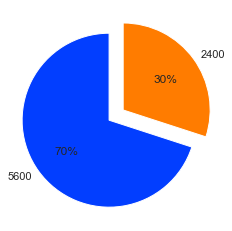

In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
#define data
data = [X_train.shape[0],X_test.shape[0] ]
labels = [data[0], data[1]]
#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:2]
#create pie chart
plt.pie(data, labels = labels, colors = colors,startangle=90, 
        autopct='%1.f%%',explode=(0.1,0.1))
plt.show()

# tune parameters

<https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/>

<https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/>

why i did not standarize my variables? <https://stats.stackexchange.com/questions/485677/does-xgboost-require-standarized-data>

## XGBOOST

In [5]:
reg = XGBRegressor(
    tree_method="hist",
    eval_metric=mean_absolute_error,
)
# grid search
n_estimators = [50, 100, 150]
max_depth = [2, 3, 4]
learning_rate = [0.05,0.1,0.3,0.5]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate= learning_rate)
grid_search = GridSearchCV(reg, param_grid, scoring="neg_mean_absolute_error", cv= 10, n_jobs=2, verbose=1)
grid_result = grid_search.fit(X_train.values, y_train.values)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


In [6]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
params = {
    'tree_method' : "hist",
    'eval_metric' : mean_absolute_error
}
params.update(grid_result.best_params_)
params

Best: -19.281135 using {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}


{'tree_method': 'hist',
 'eval_metric': <function sklearn.metrics._regression.mean_absolute_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'learning_rate': 0.05,
 'max_depth': 4,
 'n_estimators': 100}

1.0
The mean squared error (MSE) on test set: 636.6577
The mean absolute error (MAE) on test set: 19.1841
count    2400.000000
mean       19.184055
std        16.393343
min         0.006518
25%         8.259958
50%        16.152293
75%        25.424625
max       236.250694
Name: total_minutes, dtype: float64


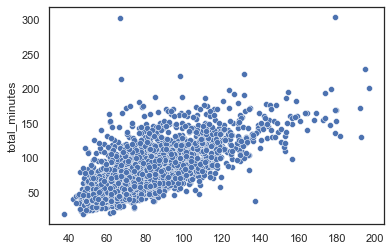

In [7]:
model_xgb = XGBRegressor(**params)
model_xgb,y_pred, error = show_test_metrics(X_train,y_train,y_test,model = model_xgb)

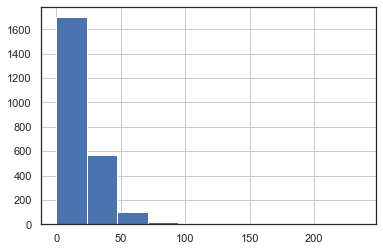

In [8]:
error.hist();

In [9]:
X_test_na = X_test[X_test.isna().any(axis=1)]
y_pred_na = model_xgb.predict(X_test_na)
y_pred_na = pd.DataFrame(y_pred_na,index=X_test_na.index)

In [10]:
file_name = "processed/xgb_reg.pkl"
# saven the model
pickle.dump(model_xgb, open(file_name, "wb"))

## Quantile Gradient Boosting

In [11]:
X_train_nona = X_train[~X_train.isna().any(axis=1)]
y_train_nona = y_train[X_train_nona .index]
X_test_nona = X_test[~X_test.isna().any(axis=1)]
y_test_nona = y_test[X_test_nona .index]

In [12]:
gbr_params = dict(
    learning_rate=0.1,
    n_estimators=150,
    max_depth=2,
    min_samples_leaf=0.01,
    min_samples_split=0.01,
)

In [13]:
reg = GradientBoostingRegressor(loss="quantile", alpha=0.5,    
                                min_samples_leaf=0.01,
                                min_samples_split=0.01)
# grid search
n_estimators = [50, 100, 150]
max_depth = [2, 3, 4]
learning_rate = [0.05,0.1,0.3,0.5]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate= learning_rate)
grid_search = GridSearchCV(reg, param_grid, scoring="neg_mean_absolute_error", cv= 10, n_jobs=2, verbose=1)
grid_result = grid_search.fit(X_train_nona.values, y_train_nona.values)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


In [14]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: -18.876017 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}


0.8848080133555927
The mean squared error (MSE) on test set: 655.2243
The mean absolute error (MAE) on test set: 18.7497


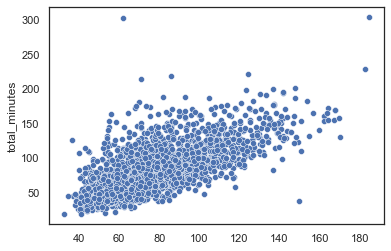

In [15]:
all_models = {}
for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **grid_result.best_params_)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train_nona, y_train_nona)
y_lower = all_models["q 0.05"].predict(X_test_nona)
y_upper = all_models["q 0.95"].predict(X_test_nona)
y_med = all_models["q 0.50"].predict(X_test_nona)
print(sum((y_upper>=y_test_nona) & (y_lower<=y_test_nona))/ len(y_test_nona))
mse = mean_squared_error(y_test_nona,y_med )
mae = mean_absolute_error(y_test_nona, y_med)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
sns.scatterplot(y=y_test_nona, x=y_med,legend=True);

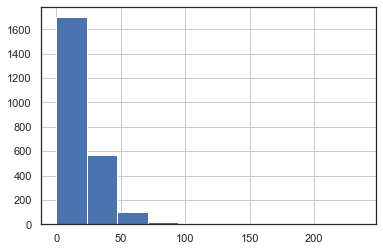

In [16]:
error.hist();

In [17]:
gbt_params = {
    'loss' : "quantile", 
    'alpha' : 0.5,
    'min_samples_leaf' : 0.01,
    'min_samples_split' : 0.01
}
gbt_params.update(grid_result.best_params_)
model = GradientBoostingRegressor(**gbt_params)
model.fit(X_train_nona,y_train_nona)

GradientBoostingRegressor(alpha=0.5, loss='quantile', min_samples_leaf=0.01,
                          min_samples_split=0.01, n_estimators=150)

In [18]:
file_name = "processed/gbq_reg.pkl"
# saven the model
pickle.dump(model, open(file_name, "wb"))

## Report metrics

* we use xgboost for data with NA and gradien boosting with quantile parameter in loss function for data with no NA

In [19]:
# predict
y_pred_nona = model.predict(X_test_nona)
y_pred_nona = pd.DataFrame(y_pred_nona,index=X_test_nona.index)

In [20]:
y_pred = y_pred_nona.append(y_pred_na)
y_pred.columns = ['total_minutes_prediction']
y_pred = y_pred.merge(y_test,left_index=True, right_index=True)

The mean squared error (MSE) on test set: 652.3514
The mean absolute error (MAE) on test set: 18.7750


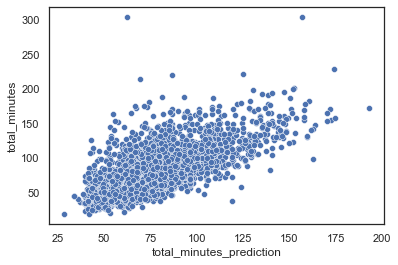

In [21]:
mse = mean_squared_error(y_pred.total_minutes,y_pred.total_minutes_prediction )
mae = mean_absolute_error(y_pred.total_minutes, y_pred.total_minutes_prediction)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
sns.scatterplot(y=y_pred.total_minutes, x=y_pred.total_minutes_prediction,legend=True);